## Introduction

In this notebook, we will create a classification model using machine learning and image processing. The model we will use is a Convolutional Neural Network, which will be trained for automated diagnosis of pigmented skin lesions. 

## Dataset

The dataset we will use is "Skin Cancer MNIST: HAM10000" dataset for skin cancer lesion classification.

Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:

Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)

It consists of a dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. 


In [254]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import cv2 as cv
from tensorflow.keras import datasets, layers, models
import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

## Data Import

### Metadata of the images

In [237]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [238]:
skin_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [206]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


### Image Data

Read images based on image ID from the CSV file.

Define image path in a new column.

Read the image arrays in a new column - resize each image.

In [239]:
# Ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}

# Define the path and add as a new column
df = skin_df.copy()
df['path'] = df['image_id'].map(image_path.get)

# Use the path to read images
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data\HAM10000_images_part_2\ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0033084.jpg,"[[[181, 164, 179], [179, 162, 176], [180, 163,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0033550.jpg,"[[[4, 5, 3], [24, 22, 21], [101, 88, 88], [128..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0033536.jpg,"[[[132, 119, 120], [157, 139, 138], [177, 158,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,data\HAM10000_images_part_2\ISIC_0032854.jpg,"[[[160, 123, 144], [163, 131, 152], [166, 128,..."


## Data Visualization

Below we graph the features of the the dataset and see the frequency of each data point. Here we can see that this dataset is quite unbalanced in terms of classification type (dx = Cell Type)

C:\Users\RaphaelleSmyth\AppData\Local\Temp\ipykernel_9284\1988463857.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


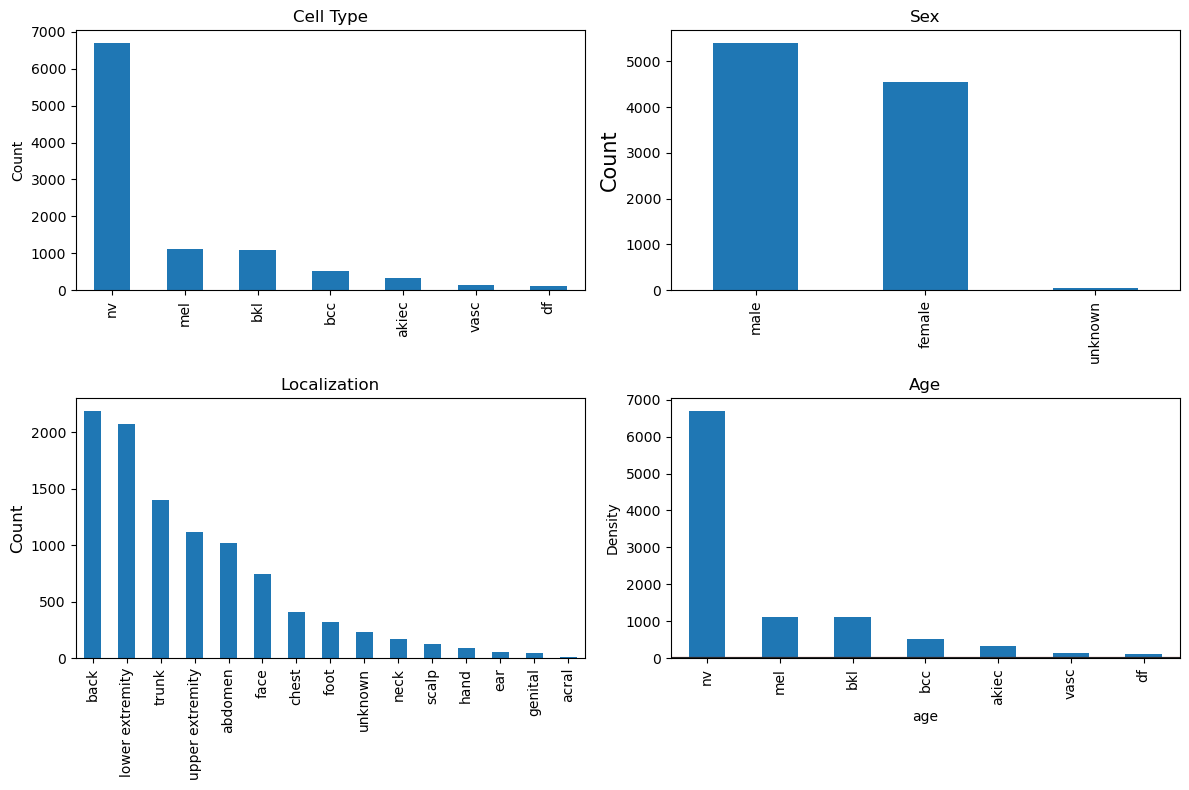

In [246]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

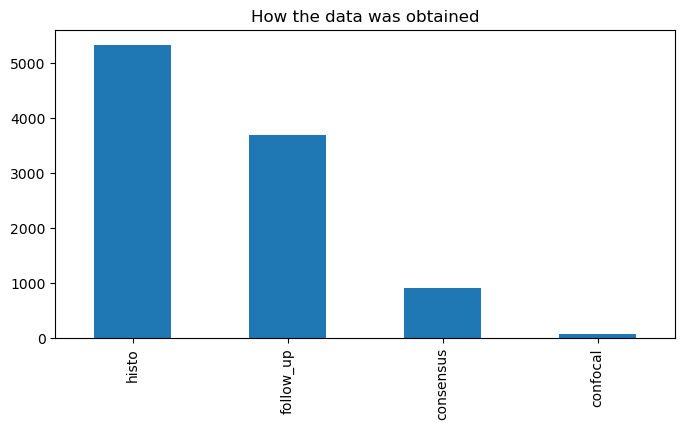

In [251]:
plt.figure(figsize=(8,4))
skin_df['dx_type'].value_counts().plot(kind='bar').set_title('How the data was obtained')
plt.show()

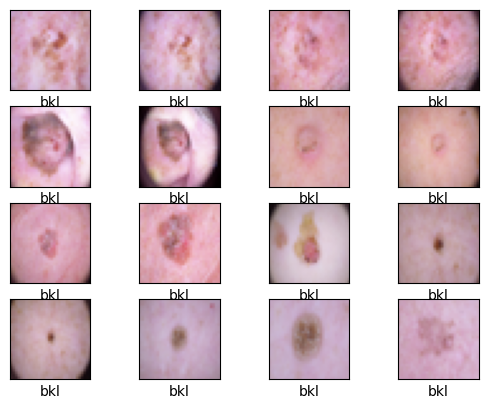

In [209]:
# print grid of images with labels
for i in range (16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(skin_df['image'][i], cmap=plt.cm.binary)
    plt.xlabel(skin_df['dx'][i])
    
plt.show()

## Data Processing 

We will assign a number to each class and create a new column with this information. This will allow for us to train the model with labels.

0 = Actinic keratoses (akiec)

1 = Basal cell carcinoma (bcc) 

2 = Benign keratosis-like lesions (bkl)

3 = Dermatofibroma (df)

4 = Melanoma (mel)

5 = Melanocytic nevi (nv)

6 = Vascular lesions (vas)

In [240]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['dx'])
LabelEncoder()

print('class names:')
print(list(le.classes_))
 
df['label'] = le.transform(df["dx"]) 

df

class names:
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data\HAM10000_images_part_1\ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data\HAM10000_images_part_2\ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,...",2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0033084.jpg,"[[[181, 164, 179], [179, 162, 176], [180, 163,...",0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0033550.jpg,"[[[4, 5, 3], [24, 22, 21], [101, 88, 88], [128...",0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0033536.jpg,"[[[132, 119, 120], [157, 139, 138], [177, 158,...",0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,data\HAM10000_images_part_2\ISIC_0032854.jpg,"[[[160, 123, 144], [163, 131, 152], [166, 128,...",0


## Training and Testing Sets

Convert the dataframe column of image data ('image') to numpy arrays so we can work with them.

The pixels of the images are from 0-255. In order to normalize the images we divid by 255 to scale the values to between 0 and 1. This makes the images more convenient to work with. 

We convert to categorical as this is a multiclass classification problem.

And finally we split the data into the training images, training labels, testing images and testing labels.
75% for training the model and 25% for testing and evaluating the model.

In [276]:
# Convert the dataframe column of images into numpy array

X = np.asarray(df['image'].tolist())
X = X/255.  

#Assign label values to Y
Y=df['label']  
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size = 0.25, random_state=42)

## Building the Model

CNN consists of three basic layers: convolution, pooling and fully connected layers. 

Convolution layers perform feature extraction by convolving the input image with a set of learned kernels. The layer typically consists of a combination of convolution operation and activation function. 

The pooling layer is used to reduce the spatial resolution of the activation map and thereby reducing the number of parameters. Pooling helps to decrease the computational cost and over-fitting. Max-pooling and average pooling are the most common methods of pooling.

Every neuron in the previous layer are connected to a fully connected (FC) layer. Features generated by the previous layer are flattened in a feature vector by the FC layer. It then performs weight updates to improve the predicting ability of feature vector.

In [268]:
# Define the model.
num_classes = 7

# defining the neural netwrok
model = Sequential()

# define the input layer, convolutional layer
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(32, 32, 3)))

# next layer, maxpooling layer, simplifying the result 
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

# another convolutional layer 
model.add(Conv2D(128, (3, 3),activation='relu'))

# next layer, maxpooling layer, simplifying the result 
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

# another convolutional layer 
model.add(Conv2D(64, (3, 3),activation='relu'))

# next layer, maxpooling layer, simplifying the result 
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

# flattening layer, making it 1 dimensional 
model.add(Flatten())

# scales all the result so they add up to 1 so that we can get - 
# a distance of probability for the indivisual classifications
model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

# Complile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 15, 15, 256)       0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 6, 6, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 6, 6, 128)       

## Fitting of the Model

In [277]:
# Train and fit the model
batch_size = 12 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
626/626 - 29s - loss: 0.5683 - acc: 0.7819 - val_loss: 0.6860 - val_acc: 0.7488 - 29s/epoch - 46ms/step
Epoch 2/50
626/626 - 34s - loss: 0.5643 - acc: 0.7823 - val_loss: 0.6737 - val_acc: 0.7624 - 34s/epoch - 55ms/step
Epoch 3/50
626/626 - 33s - loss: 0.5564 - acc: 0.7908 - val_loss: 0.6760 - val_acc: 0.7520 - 33s/epoch - 53ms/step
Epoch 4/50
626/626 - 33s - loss: 0.5645 - acc: 0.7891 - val_loss: 0.6462 - val_acc: 0.7680 - 33s/epoch - 52ms/step
Epoch 5/50
626/626 - 33s - loss: 0.5476 - acc: 0.7902 - val_loss: 0.6538 - val_acc: 0.7576 - 33s/epoch - 52ms/step
Epoch 6/50
626/626 - 33s - loss: 0.5479 - acc: 0.7932 - val_loss: 0.6752 - val_acc: 0.7520 - 33s/epoch - 52ms/step
Epoch 7/50
626/626 - 33s - loss: 0.5504 - acc: 0.7880 - val_loss: 0.6546 - val_acc: 0.7668 - 33s/epoch - 53ms/step
Epoch 8/50
626/626 - 39s - loss: 0.5444 - acc: 0.7935 - val_loss: 0.6802 - val_acc: 0.7508 - 39s/epoch - 62ms/step
Epoch 9/50
626/626 - 38s - loss: 0.5376 - acc: 0.7911 - val_loss: 0.6582 - val_a

## Plotting the training Results

The training loss is the average of the losses over each batch of training data.
The validation loss for an epoch is computed using the model as it is at the end of the epoch.

As loss is seen to decrease steadily and validation loss is rising slightly, this is an indication that the model may be over fitting. In order to correct this:
- fixes include regularisation or change some data.

The consistancy of the validation loss ( straight line across ) means that not able to learn or reduce the loss of that particular training data. This could be indicating a bias issue. 

- take a look at the training data again
- we may to to try a larger neural network or a more sophisticated neural network.

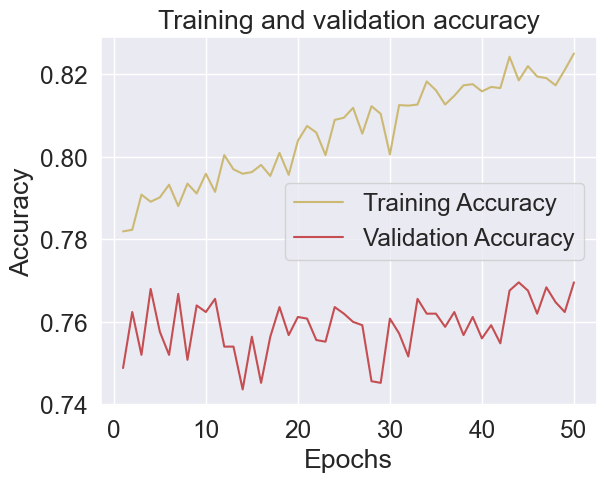

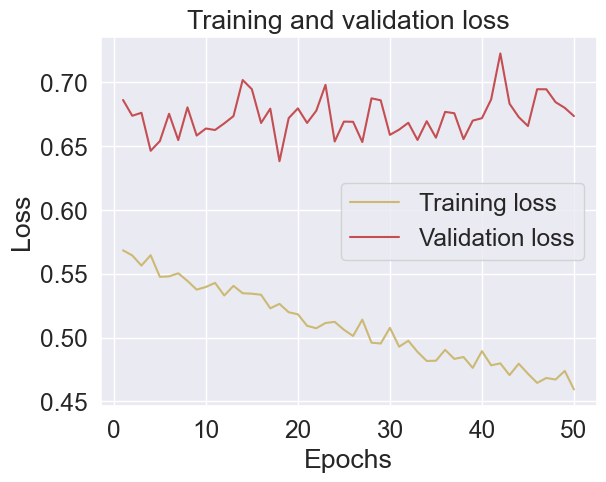

In [278]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Fraction of incorrect predictions')

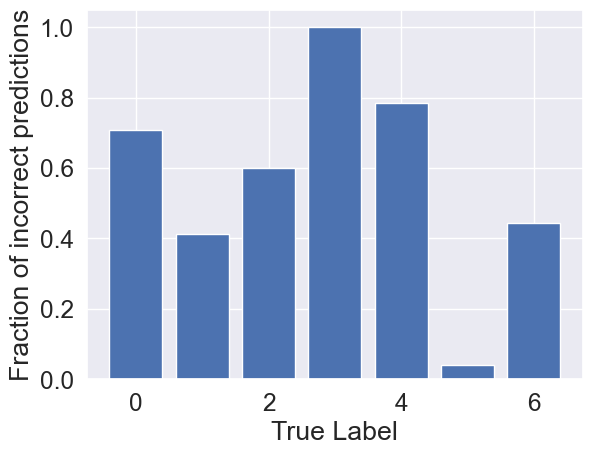

In [258]:
# Prediction on test data
y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')